In [47]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import evaluate
from collections import Counter

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# STEP 3: Load and Explore Dataset
# =============================================================================
# Load your dataset
ds = load_dataset("ButterChicken98/plantvillage-image-text-pairs")
print("Dataset structure:")
print(ds)

# Explore the data
print(f"\nNumber of training samples: {len(ds['train'])}")
print(f"Sample data structure: {ds['train'][0].keys()}")

# Look at a few examples
for i in range(3):
    sample = ds['train'][i]
    print(f"\nSample {i+1}:")
    print(f"Caption: {sample['caption']}")
    if 'captions' in sample:
        print(f"Captions list: {sample['captions']}")

# =============================================================================
# STEP 4: Prepare Labels and Create Label Mappings
# =============================================================================
# Extract unique labels from captions
all_captions = [item['caption'] for item in ds['train']]
unique_labels = list(set(all_captions))
unique_labels.sort()  # Sort for consistency

print(f"\nFound {len(unique_labels)} unique classes:")
for i, label in enumerate(unique_labels[:10]):  # Show first 10
    print(f"{i}: {label}")

# Create label mappings
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for idx, label in enumerate(unique_labels)}

print(f"\nLabel distribution:")
label_counts = Counter(all_captions)
for label, count in sorted(label_counts.items())[:5]:  # Show top 5
    print(f"{label}: {count} samples")

# =============================================================================
# STEP 5: Load Pre-trained Model and Processor
# =============================================================================
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

# Load model with the correct number of classes
num_labels = len(unique_labels)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Important for different number of classes
)

print(f"Model loaded with {num_labels} classes")

# =============================================================================
# STEP 6: Data Preprocessing
# =============================================================================
def preprocess_function(examples):
    """Preprocess images and labels for training"""
    # Process images
    images = [image.convert("RGB") for image in examples['image']]
    inputs = processor(images, return_tensors="pt")

    # Process labels
    labels = [label2id[caption] for caption in examples['caption']]
    inputs['labels'] = torch.tensor(labels)

    return inputs

# Apply preprocessing
print("Preprocessing dataset...")
processed_dataset = ds['train'].map(
    preprocess_function,
    batched=True,
    batch_size=32,
    remove_columns=ds['train'].column_names
)

# =============================================================================
# STEP 7: Split Dataset into Train/Validation
# =============================================================================
# Split dataset (80% train, 20% validation)
train_test_split = processed_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

# =============================================================================
# STEP 8: Define Metrics
# =============================================================================
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    # Calculate precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# =============================================================================
# STEP 9: Training Configuration
# =============================================================================
# Create output directory
output_dir = "./vit-plantvillage-finetuned"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Start with fewer epochs
    learning_rate=2e-5,
    warmup_steps=500,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to=None,  # Disable wandb logging
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    dataloader_pin_memory=False,  # Can help with memory issues
)

print("Training configuration:")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Learning rate: {training_args.learning_rate}")

# =============================================================================
# STEP 10: Initialize Trainer and Start Training
# =============================================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=processor,  # For saving preprocessing info
)

print("Starting training...")
print("This may take a while depending on your dataset size and GPU...")

# Train the model
trainer.train()

# =============================================================================
# STEP 11: Evaluate the Model
# =============================================================================
print("\nEvaluating model...")
eval_results = trainer.evaluate()

print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# =============================================================================
# STEP 12: Save the Model
# =============================================================================
print(f"\nSaving model to {output_dir}")
trainer.save_model()
processor.save_pretrained(output_dir)

print("Training completed successfully!")

Using device: cuda
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'caption', 'captions'],
        num_rows: 20638
    })
})

Number of training samples: 20638
Sample data structure: dict_keys(['image', 'caption', 'captions'])

Sample 1:
Caption: Tomato healthy
Captions list: ['A vibrant green and healthy tomato leaf with smooth, spotless surface.', 'A healthy Solanum lycopersicum leaf, free of disease or pests, with a uniform green color.', 'A fresh tomato leaf outdoors, glowing in sunlight with a smooth and unblemished surface.', 'A clean and healthy tomato leaf image, perfect for comparison in plant health datasets.']

Sample 2:
Caption: Tomato Late blight
Captions list: ['A tomato leaf showing dark brown lesions and water-soaked edges, symptoms of late blight disease.', 'A tomato leaf infected with Phytophthora infestans, featuring characteristic necrotic patches and chlorosis.', 'A tomato plant leaf outdoors, visibly damaged by late blight with br

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 15 classes
Preprocessing dataset...


Map:   0%|          | 0/20638 [00:00<?, ? examples/s]

Training samples: 16510
Validation samples: 4128
Training configuration:
Batch size: 16
Epochs: 3
Learning rate: 2e-05


/tmp/ipython-input-3203620504.py:175: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...
This may take a while depending on your dataset size and GPU...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.146600,0.132067,0.968266,0.968632,0.970216,0.968266
1000,0.036800,0.025396,0.992733,0.992732,0.992779,0.992733
1500,0.003700,0.024440,0.992490,0.992499,0.992613,0.992490
2000,0.010200,0.015333,0.996124,0.996126,0.996178,0.996124
2500,0.000800,0.009313,0.997335,0.997331,0.997346,0.997335
3000,0.001100,0.008812,0.997335,0.997333,0.997353,0.997335



Evaluating model...


Evaluation Results:
eval_loss: 0.0153
eval_accuracy: 0.9961
eval_f1: 0.9961
eval_precision: 0.9962
eval_recall: 0.9961
eval_runtime: 492.6753
eval_samples_per_second: 8.3790
eval_steps_per_second: 0.5240
epoch: 3.0000

Saving model to ./vit-plantvillage-finetuned
Training completed successfully!


In [62]:
import os
import zipfile
from google.colab import files

# =============================================================================
# METHOD 1: Download as ZIP file (Recommended)
# =============================================================================
def create_model_zip(model_dir="./vit-plantvillage-finetuned", zip_name="vit-plantvillage-model.zip"):
    """Create a ZIP file of the model directory and download it"""

    # Check if model directory exists
    if not os.path.exists(model_dir):
        print(f"Error: Model directory {model_dir} not found!")
        return

    # Create ZIP file
    print(f"Creating ZIP file: {zip_name}")
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(model_dir):
            for file in files:
                file_path = os.path.join(root, file)
                # Add file to ZIP with relative path
                arcname = os.path.relpath(file_path, os.path.dirname(model_dir))
                zipf.write(file_path, arcname)
                print(f"Added: {arcname}")

    print(f"ZIP file created successfully!")
    print(f"File size: {os.path.getsize(zip_name) / (1024*1024):.1f} MB")
# Create and download the model ZIP
create_model_zip()

Creating ZIP file: vit-plantvillage-model.zip
Added: vit-plantvillage-finetuned/config.json
Added: vit-plantvillage-finetuned/model.safetensors
Added: vit-plantvillage-finetuned/training_args.bin
Added: vit-plantvillage-finetuned/preprocessor_config.json
Added: vit-plantvillage-finetuned/runs/Aug15_10-18-25_f118b448f514/events.out.tfevents.1755253107.f118b448f514.700.11
Added: vit-plantvillage-finetuned/runs/Aug15_10-18-25_f118b448f514/events.out.tfevents.1755263613.f118b448f514.700.12
Added: vit-plantvillage-finetuned/checkpoint-3096/optimizer.pt
Added: vit-plantvillage-finetuned/checkpoint-3096/config.json
Added: vit-plantvillage-finetuned/checkpoint-3096/trainer_state.json
Added: vit-plantvillage-finetuned/checkpoint-3096/model.safetensors
Added: vit-plantvillage-finetuned/checkpoint-3096/rng_state.pth
Added: vit-plantvillage-finetuned/checkpoint-3096/scheduler.pt
Added: vit-plantvillage-finetuned/checkpoint-3096/training_args.bin
Added: vit-plantvillage-finetuned/checkpoint-3096/pr

In [49]:
from google.colab import files
# Download just the essential files
files.download('./vit-plantvillage-finetuned/config.json')
files.download('./vit-plantvillage-finetuned/model.safetensors')
files.download('./vit-plantvillage-finetuned/preprocessor_config.json')
files.download('./vit-plantvillage-finetuned/training_args.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading your trained model...
✅ Model loaded successfully!
📊 Model can classify 15 different plant conditions

🏷️ Some classes your model can identify:
  0: Pepper bell Bacterial spot
  1: Pepper bell healthy
  2: Potato Early blight
  3: Potato Late blight
  4: Potato healthy
  5: Tomato Bacterial spot
  6: Tomato Early blight
  7: Tomato Late blight
  8: Tomato Leaf Mold
  9: Tomato Septoria leaf spot
  ... and 5 more classes

🧪 TESTING YOUR MODEL
📤 Upload a plant image to test your model...


Saving 8acca2d85efee656d8cf914ccc512d3a.jpeg to 8acca2d85efee656d8cf914ccc512d3a (2).jpeg
✅ Image uploaded: 8acca2d85efee656d8cf914ccc512d3a (2).jpeg
🔮 Making prediction on: 8acca2d85efee656d8cf914ccc512d3a (2).jpeg
📷 Image loaded: (500, 331) pixels

🎯 PREDICTION RESULTS:
----------------------------------------
1. Tomato Early blight
   Confidence: 0.6485 (64.9%)

2. Tomato Late blight
   Confidence: 0.1301 (13.0%)

3. Pepper bell Bacterial spot
   Confidence: 0.0688 (6.9%)

4. Tomato Septoria leaf spot
   Confidence: 0.0441 (4.4%)

5. Potato Early blight
   Confidence: 0.0350 (3.5%)



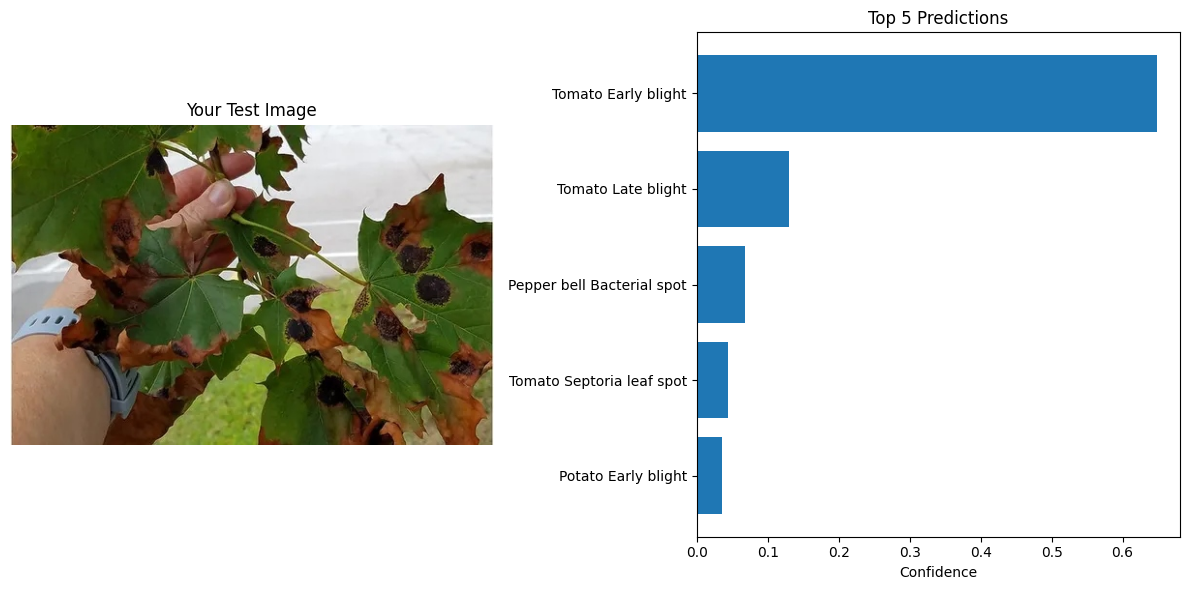

🏆 TOP PREDICTION: Tomato Early blight
🎯 CONFIDENCE: 64.9%
⚠️ Moderate confidence prediction

🎉 MODEL TESTING COMPLETE!
💡 Tips for better results:
• Use clear, well-lit plant images
• Ensure the plant/disease is the main subject
• Images similar to your training data work best
• Try different angles if confidence is low


In [60]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os


# The model files are in the vit-plantvillage-finetuned directory
MODEL_PATH = "./vit-plantvillage-finetuned"

print("Loading your trained model...")
try:
    # Load the model and processor
    model = ViTForImageClassification.from_pretrained(MODEL_PATH)
    processor = ViTImageProcessor.from_pretrained(MODEL_PATH)

    print("✅ Model loaded successfully!")
    print(f"📊 Model can classify {len(model.config.id2label)} different plant conditions")

    # Show some example classes
    print("\n🏷️ Some classes your model can identify:")
    class_names = list(model.config.id2label.values())
    for i, class_name in enumerate(class_names[:10]):  # Show first 10
        print(f"  {i}: {class_name}")
    if len(class_names) > 10:
        print(f"  ... and {len(class_names)-10} more classes")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure the model files are in ./vit-plantvillage-finetuned/")
    exit()

# =============================================================================
# STEP 2: PREDICTION FUNCTION
# =============================================================================

def predict_plant_disease(image_path, model, processor, top_k=5):
    """
    Predict plant disease from an image

    Args:
        image_path: Path to the image file
        model: Loaded ViT model
        processor: Image processor
        top_k: Number of top predictions to show

    Returns:
        predictions: List of (class_name, confidence) tuples
    """
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        print(f"📷 Image loaded: {image.size} pixels")

        # Process the image
        inputs = processor(image, return_tensors="pt")

        # Make prediction
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get top-k predictions
        top_predictions = torch.topk(predictions, top_k)

        results = []
        for i in range(top_k):
            class_idx = top_predictions.indices[0][i].item()
            confidence = top_predictions.values[0][i].item()
            class_name = model.config.id2label[class_idx]
            results.append((class_name, confidence))

        return results, image

    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None, None

# =============================================================================
# STEP 3: TEST WITH AN IMAGE
# =============================================================================

def test_model():
    """Test the model with an uploaded image"""

    print("\n" + "="*60)
    print("🧪 TESTING YOUR MODEL")
    print("="*60)

    # Upload a plant image to test
    print("📤 Upload a plant image to test your model...")
    uploaded = files.upload()

    if uploaded:
        # Get the uploaded image path
        image_path = list(uploaded.keys())[0]
        print(f"✅ Image uploaded: {image_path}")

        # Make prediction
        print(f"🔮 Making prediction on: {image_path}")
        results, image = predict_plant_disease(image_path, model, processor, top_k=5)

        if results:
            print("\n🎯 PREDICTION RESULTS:")
            print("-" * 40)
            for i, (class_name, confidence) in enumerate(results, 1):
                print(f"{i}. {class_name}")
                print(f"   Confidence: {confidence:.4f} ({confidence*100:.1f}%)")
                print()

            # Show the image with prediction
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Your Test Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            classes = [result[0][:30] + "..." if len(result[0]) > 30 else result[0]
                      for result in results]  # Truncate long names
            confidences = [result[1] for result in results]

            plt.barh(range(len(classes)), confidences)
            plt.yticks(range(len(classes)), classes)
            plt.xlabel('Confidence')
            plt.title('Top 5 Predictions')
            plt.gca().invert_yaxis()

            plt.tight_layout()
            plt.show()

            # Print top prediction
            top_class, top_confidence = results[0]
            print(f"🏆 TOP PREDICTION: {top_class}")
            print(f"🎯 CONFIDENCE: {top_confidence*100:.1f}%")

            if top_confidence > 0.8:
                print("✅ High confidence prediction!")
            elif top_confidence > 0.5:
                print("⚠️ Moderate confidence prediction")
            else:
                print("❓ Low confidence - model is uncertain")

    else:
        print("❌ No image uploaded. Please upload an image to test the model.")

# =============================================================================
# RUN THE TEST
# =============================================================================

# Test the model
test_model()

# =============================================================================
# ADDITIONAL TESTING FUNCTIONS
# =============================================================================

def batch_test_images(image_folder_path):
    """Test multiple images in a folder"""
    import os
    import glob

    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []

    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(image_folder_path, ext)))

    print(f"Found {len(image_files)} images to test...")

    for img_path in image_files:
        print(f"\n📷 Testing: {os.path.basename(img_path)}")
        results, _ = predict_plant_disease(img_path, model, processor, top_k=3)
        if results:
            top_class, top_confidence = results[0]
            print(f"   🎯 Prediction: {top_class} ({top_confidence*100:.1f}%)")

# Uncomment to test multiple images in a folder
# batch_test_images("path/to/your/image/folder")

print("\n" + "="*60)
print("🎉 MODEL TESTING COMPLETE!")
print("="*60)
print("💡 Tips for better results:")
print("• Use clear, well-lit plant images")
print("• Ensure the plant/disease is the main subject")
print("• Images similar to your training data work best")
print("• Try different angles if confidence is low")

In [63]:
files.download('/content/vit-plantvillage-model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>